In [6]:
# import modules
%matplotlib inline
import matplotlib.pylab as plt
import os
import numpy as np
import pandas as pd
from scipy.misc import imread

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2

In [7]:
# to stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [8]:
# set path
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'Data')
# load data
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

train_x = train_x / 255.

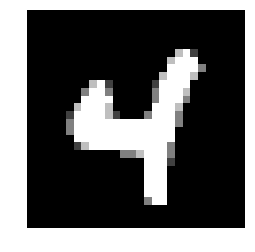

In [10]:
# print image
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten=True)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
# define vars 
g_input_shape = 100 
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
epochs = 25 
batch_size = 128

In [12]:
# generator
model_1 = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    
    Reshape(d_input_shape),
])

# discriminator
model_2 = Sequential([
    InputLayer(input_shape=d_input_shape),
    
    Flatten(),
        
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

In [13]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               392784    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 693,784
Trainable params: 693,784
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 643,501
Trainable params: 643,501
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

In [16]:
gan = simple_gan(model_1, model_2, normal_latent_sampling((100,)))
model = AdversarialModel(base_model=gan,player_params=[model_1.trainable_weights, model_2.trainable_weights])
model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(), player_optimizers=['adam', 'adam'], loss='binary_crossentropy')

In [24]:
train_x_1 = train_x[train["label"] == 1]

In [29]:
# It is a Keras-2 rename. Fixed in master now. This is the block that makes it work in keras-2.
model._feed_output_shapes = model.internal_output_shapes
model._feed_loss_fns = model.loss_functions
model._feed_input_names = model.input_names
model._feed_input_shapes = model.internal_input_shapes
model._feed_outputs = model.outputs
model._feed_output_names = model.output_names
model._feed_sample_weights =model.sample_weights
model._feed_sample_weight_modes = model.sample_weight_modes
history = model.fit(x=train_x_1, y=gan_targets(train_x_1.shape[0]), epochs=50, batch_size=batch_size, verbose=2)

Epoch 1/50
3s - loss: 23.3677 - player_0_loss: 22.5302 - player_0_yfake_loss: 11.2247 - player_0_yreal_loss: 10.4804 - player_1_loss: 0.8375 - player_1_yfake_loss: 0.0038 - player_1_yreal_loss: 0.0085
Epoch 2/50
3s - loss: 19.2181 - player_0_loss: 18.3860 - player_0_yfake_loss: 8.1995 - player_0_yreal_loss: 9.3651 - player_1_loss: 0.8321 - player_1_yfake_loss: 0.0037 - player_1_yreal_loss: 0.0070
Epoch 3/50
3s - loss: 16.8851 - player_0_loss: 16.0581 - player_0_yfake_loss: 6.8188 - player_0_yreal_loss: 8.4206 - player_1_loss: 0.8270 - player_1_yfake_loss: 0.0036 - player_1_yreal_loss: 0.0049
Epoch 4/50
3s - loss: 16.2515 - player_0_loss: 15.4391 - player_0_yfake_loss: 6.5466 - player_0_yreal_loss: 8.0879 - player_1_loss: 0.8124 - player_1_yfake_loss: 0.0041 - player_1_yreal_loss: 0.0037
Epoch 5/50
3s - loss: 17.8082 - player_0_loss: 17.0148 - player_0_yfake_loss: 7.5176 - player_0_yreal_loss: 8.7107 - player_1_loss: 0.7934 - player_1_yfake_loss: 0.0035 - player_1_yreal_loss: 0.0034
Epo

3s - loss: 19.7130 - player_0_loss: 19.0557 - player_0_yfake_loss: 5.2791 - player_0_yreal_loss: 13.1487 - player_1_loss: 0.6573 - player_1_yfake_loss: 0.0112 - player_1_yreal_loss: 0.0182
Epoch 43/50
3s - loss: 20.5104 - player_0_loss: 19.8519 - player_0_yfake_loss: 5.5954 - player_0_yreal_loss: 13.6344 - player_1_loss: 0.6586 - player_1_yfake_loss: 0.0140 - player_1_yreal_loss: 0.0225
Epoch 44/50
3s - loss: 19.0085 - player_0_loss: 18.3316 - player_0_yfake_loss: 4.7634 - player_0_yreal_loss: 12.9513 - player_1_loss: 0.6769 - player_1_yfake_loss: 0.0211 - player_1_yreal_loss: 0.0390
Epoch 45/50
3s - loss: 21.6545 - player_0_loss: 20.9651 - player_0_yfake_loss: 6.7422 - player_0_yreal_loss: 13.5668 - player_1_loss: 0.6895 - player_1_yfake_loss: 0.0106 - player_1_yreal_loss: 0.0228
Epoch 46/50
3s - loss: 20.8353 - player_0_loss: 20.1551 - player_0_yfake_loss: 6.0478 - player_0_yreal_loss: 13.4383 - player_1_loss: 0.6802 - player_1_yfake_loss: 0.0044 - player_1_yreal_loss: 0.0069
Epoch 4

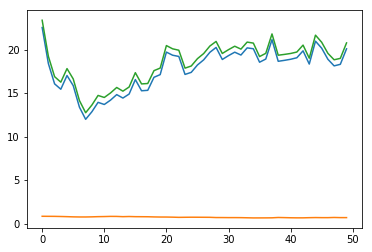

In [30]:
plt.plot(history.history['player_0_loss'])
plt.plot(history.history['player_1_loss'])
plt.plot(history.history['loss'])

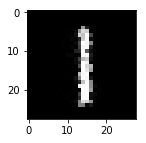

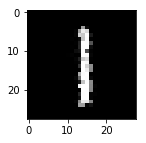

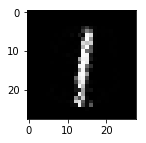

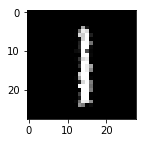

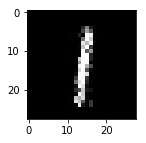

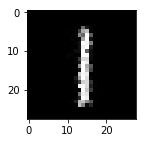

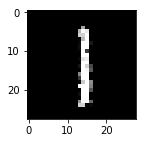

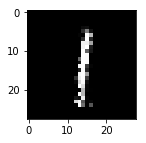

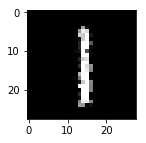

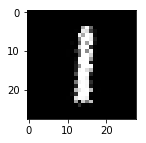

In [36]:
zsamples = np.random.normal(size=(10, 100))
pred = model_1.predict(zsamples)
for i in range(pred.shape[0]):
    plt.figure(figsize=(2,2))
    plt.imshow(pred[i, :], cmap='gray')
    plt.show()